In [1]:
"""Plots the loss of the model & performs basic evaluation.
"""

'Plots the loss of the model & performs basic evaluation.\n'

In [21]:
import pathlib
import torch
from typing import List, Union, Tuple
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from data_loader import train_dataloader, test_dataloader
from model import model

In [3]:
def plot_loss(
    model_name: str, train_loss: List[float], valid_loss: List[float]
) -> None:
    """Visualizes the loss data of the trained model.

    Args:
        model_name: Name of the trained model.
        train_loss: Loss data generated during training.
        valid_loss: Loss data generated during validation.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(model_name + " loss values")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [4]:
def txt_to_list(input_path: Union[pathlib.Path, str]) -> List[str]:
    """Loads a .txt file into a list.
    Args:
        input_path: Input path to the txt file.

    Returns:
        List containing data from the .txt file.
    """
    with open(input_path, "r") as f:
        data = f.read().splitlines()
    
    return data

In [6]:
model_name = 'lr_1_e_m4_b_4_e_10000_deeper'

In [7]:
TRAINED_MODEL_PATH = f'./trained_models/{model_name}.pt'
TRAIN_LOSS_PATH = f'./trained_models/{model_name}_training_loss.txt'
VALID_LOSS_PATH = f'./trained_models/{model_name}_validation_loss.txt'

In [8]:
model_name = pathlib.Path(TRAINED_MODEL_PATH).stem
train_loss= txt_to_list(TRAIN_LOSS_PATH)
valid_loss= txt_to_list(VALID_LOSS_PATH)

In [9]:
# Convert str to float & tidy up.
train_loss = [float(el) for el in train_loss]
train_loss = [round(el, 4) for el in train_loss]

valid_loss = [float(el) for el in valid_loss]
valid_loss = [round(el, 4) for el in valid_loss]

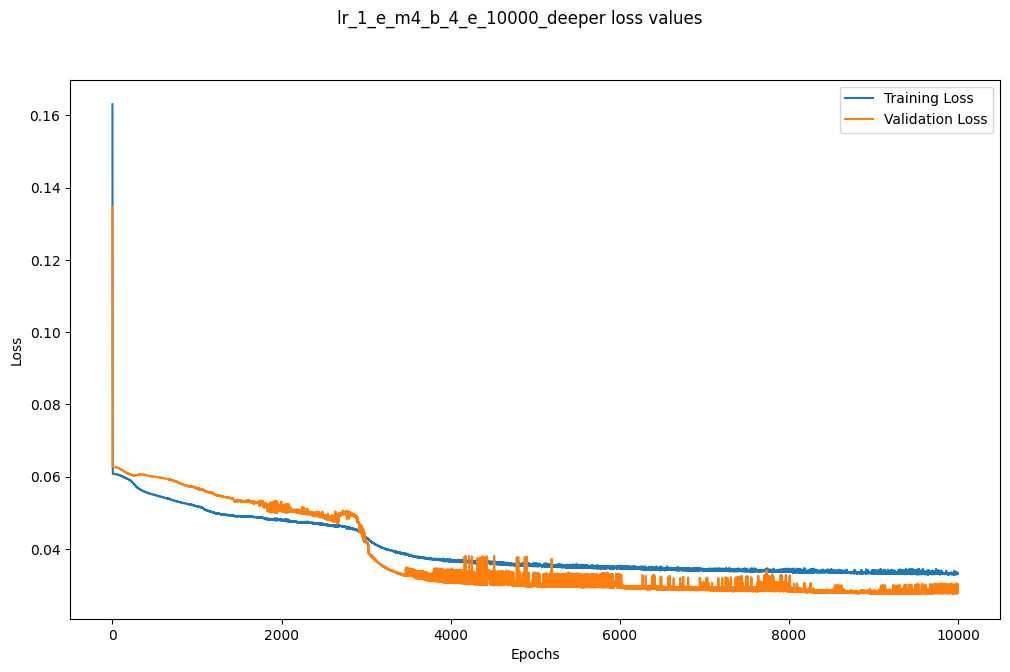

In [10]:
plot_loss(model_name, train_loss, valid_loss)

In [13]:
TRAINED_STATE_DICT_PATH = f'./trained_models/{model_name}_state_dict'

In [14]:
# Set the device & clean the memory.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda:0


In [15]:
# Load the trained model state dictionary.
model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))

/tmp/ipykernel_257766/2031099296.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))


<All keys matched successfully>

In [16]:
# Pre - normalization min and max values of output variables.
x_load_min = 49.78
x_load_max = 998679
y_load_min = 0.782819
y_load_max = 999488

In [19]:
# Evaluate the model.
generalization_errors_x = []
generalization_errors_y = []
for batch_features, batch_labels in test_dataloader:
    outputs = model(batch_features)
    predicted_labels = outputs.detach().numpy()

    for i in range(len(batch_features)):
        features = batch_features[i]
        labels = batch_labels[i]
        predicted = predicted_labels[i]

        print("Features:")
        print(features)

        print("Predicted Labels:")
        # Scale the predictions and ground truth labels back to nominal range.
        x_load_pred = predicted[0] * (x_load_max - x_load_min) + x_load_min
        y_load_pred = predicted[1] * (y_load_max - y_load_min) + y_load_min
        print("Predicted X Load:,", x_load_pred)
        print("Predicted Y Load:,", y_load_pred)

        print("Actual Labels:")
        x_load_actual = labels.numpy()[0] * (x_load_max - x_load_min) + x_load_min
        y_load_actual = labels.numpy()[1] * (y_load_max - y_load_min) + y_load_min
        print("Actual X Load:,", x_load_actual)
        print("Actual Y Load:,", y_load_actual)

        generalization_error_x = round(abs(x_load_pred - x_load_actual), 4)
        generalization_error_y = round(abs(y_load_pred - y_load_actual), 4)
        print('Error X:', generalization_error_x)
        print('Error Y:', generalization_error_y)
        generalization_errors_x.append(generalization_error_x)
        generalization_errors_y.append(generalization_error_y)

        print("------------------")

Features:
tensor([0.1212, 0.5000, 0.2000, 1.0000])
Predicted Labels:
Predicted X Load:, 228582.95909017025
Predicted Y Load:, 126946.29742540045
Actual Labels:
Actual X Load:, 300963.00284075737
Actual Y Load:, 123914.99693216494
Error X: 72380.0438
Error Y: 3031.3005
------------------
Features:
tensor([0.0552, 0.2000, 0.2000, 1.5000])
Predicted Labels:
Predicted X Load:, 242330.25824831187
Predicted Y Load:, 447604.7391044137
Actual Labels:
Actual X Load:, 131409.00673410445
Actual Y Load:, 427363.9984361542
Error X: 110921.2515
Error Y: 20240.7407
------------------
Features:
tensor([0.1969, 0.5000, 0.2000, 1.0000])
Predicted Labels:
Predicted X Load:, 309997.00776277005
Predicted Y Load:, 162028.87771319784
Actual Labels:
Actual X Load:, 339473.98783163313
Actual Y Load:, 165921.9991957707
Error X: 29476.9801
Error Y: 3893.1215
------------------
Features:
tensor([0.0778, 0.3000, 0.2000, 1.5000])
Predicted Labels:
Predicted X Load:, 194441.40431150317
Predicted Y Load:, 872332.2484

In [23]:
generalization_errors_x = np.array(generalization_errors_x)
mae_x = np.sum(generalization_errors_x / np.shape(generalization_errors_x)[0])
mse_x = np.sum(generalization_errors_x**2 / np.shape(generalization_errors_x)[0])
rmse_x = np.sqrt(mse_x)

generalization_errors_y = np.array(generalization_errors_y)
mae_y = np.sum(generalization_errors_y / np.shape(generalization_errors_y)[0])
mse_y = np.sum(generalization_errors_y**2 / np.shape(generalization_errors_y)[0])
rmse_y = np.sqrt(mse_y)

In [24]:
print('Total evaluation metrics - Load X')
print('MAE:', np.round(mae_x, 4))
print('MSE:', np.round(mse_x, 4))
print('RMSE:', np.round(rmse_x, 4))

Total evaluation metrics - Load X
MAE: 105178.613
MSE: 30250723087.7188
RMSE: 173927.35


In [25]:
print('Total evaluation metrics - Load Y')
print('MAE:', np.round(mae_y, 4))
print('MSE:', np.round(mse_y, 4))
print('RMSE:', np.round(rmse_y, 4))

Total evaluation metrics - Load Y
MAE: 111355.2315
MSE: 29310894604.1012
RMSE: 171204.2482


In [16]:
features

tensor([0.0571, 0.2000, 0.2000, 1.5000])

In [21]:
labels

tensor([0.0010, 0.3964])